Unique attack types: ['BENIGN' 'DDoS']
Cross-validation Accuracy Scores: [0.99895833 1.         1.         1.         0.996875  ]
Mean CV Accuracy: 0.9992

Classification Report:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       600
        DDoS       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Confusion Matrix:
 [[599   1]
 [  1 599]]


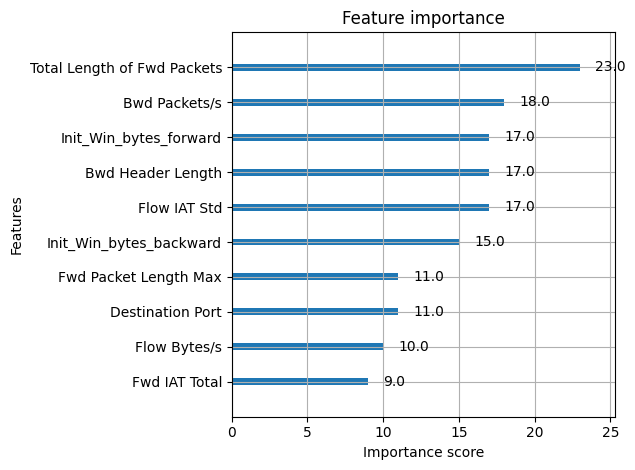

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

# Clean column names
df.columns = df.columns.str.strip()

# Show unique labels (multi-class)
print("Unique attack types:", df['Label'].unique())

# Remove infinite and NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Downsample the top 4 most frequent classes (including BENIGN) for balance
top_classes = df['Label'].value_counts().nlargest(4).index.tolist()
df = df[df['Label'].isin(top_classes)]

# Sample 3000 from each class
df_sampled = df.groupby('Label').apply(lambda x: x.sample(n=3000, random_state=42)).reset_index(drop=True)

# Split into features and target
X = df_sampled.drop('Label', axis=1)
y = df_sampled['Label']

# Encode labels to integers for XGBoost
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Drop near-zero variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support()]
X = pd.DataFrame(X_reduced, columns=selected_columns)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Cross-validation (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
import xgboost as xgb
xgb.plot_importance(model, max_num_features=10)
plt.tight_layout()
plt.show()
